<h3>Prepare the Working Space<h3>

To do object detection (in this case Dog and Cat detection), I am going to use the Mask R-CNN model and its weights that trained on COCO dataset. You might want to take a look at the [Mask R-CNN github repository](https://github.com/matterport/Mask_RCNN) and [COCO dataset](https://cocodataset.org). Let's begin.

In [ ]:
# Firstly, I cloned the repository to my colab vm
!git clone https://github.com/matterport/Mask_RCNN.git 

# and I installed it
%cd Mask_RCNN/
!python setup.py install

# Checking of whether it was installed correctly or not
!pip show mask-rcnn

# After the installing, I installed model weights too
!wget https://github.com/matterport/Mask_RCNN/releases/download/v2.0/mask_rcnn_coco.h5

# To download the dataset from kaggle with kaggle api to directly in colab, I mounted my drive to the colab and fetched my kaggle credentials file.
from google.colab import drive
drive.mount("/content/gdrive")

!mkdir /root/.kaggle
!cp ../gdrive/MyDrive/kaggle/kaggle.json /root/.kaggle

# Downloading of the dataset
!kaggle datasets download -d andrewmvd/dog-and-cat-detection

# Extract dataset 
import zipfile

with zipfile.ZipFile("dog-and-cat-detection.zip") as zip_file:
    zip_file.extractall("../dog_vs_cat")

Cloning into 'Mask_RCNN'...
remote: Enumerating objects: 956, done.
remote: Total 956 (delta 0), reused 0 (delta 0), pack-reused 956
Receiving objects: 100% (956/956), 125.23 MiB | 32.94 MiB/s, done.
Resolving deltas: 100% (562/562), done.
/content/Mask_RCNN
running install
running bdist_egg
running egg_info
creating mask_rcnn.egg-info
writing mask_rcnn.egg-info/PKG-INFO
writing dependency_links to mask_rcnn.egg-info/dependency_links.txt
writing top-level names to mask_rcnn.egg-info/top_level.txt
writing manifest file 'mask_rcnn.egg-info/SOURCES.txt'
reading manifest template 'MANIFEST.in'
writing manifest file 'mask_rcnn.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib
running build_py
creating build
creating build/lib
creating build/lib/mrcnn
copying mrcnn/parallel_model.py -> build/lib/mrcnn
copying mrcnn/config.py -> build/lib/mrcnn
copying mrcnn/model.py -> build/lib/mrcnn
copying mrcnn/visualize.py -> build/lib/mrcnn
copying mrcnn/

The Mask R-CNN model works with `tensorflow==1.15.3` and `keras==2.2.4`. But as you can it also works fine with `tensorflow==1.15.2`. Since I use colab, I just switched the tensorflow version. To install correct version of keras, just type `!pip install keras==2.2.4` and after installed correctly, restart the runtime.


In [ ]:
%tensorflow_version 1.x
!pip install keras==2.2.4

import tensorflow as tf
print(tf.__version__)

import keras
print(keras.__version__)

TensorFlow 1.x selected.
1.15.2
2.2.4


Using TensorFlow backend.


<h3>Prepare the Dataset<h3>

In [ ]:
import os 
import numpy as np
import xml

In [ ]:
# Mask R-CNN requires a dataset object to handle the dataset.
# So, I created a dataset object that derived from mrcnn.utils.Dataset

from mrcnn.utils import Dataset

class DogvsCat(Dataset):
    # we need a method that load the dataset, you can name this method as you want
    def load_dataset(self, dataset_dir, is_train=True):
        self.add_class("dataset", 1, "dog")              # defining of number of classes in the dataset
        self.add_class("dataset", 2, "cat")

        images_dir = os.path.join(dataset_dir, "images")
        annotations_dir = os.path.join(dataset_dir, "annotations")

        for file_name in os.listdir(images_dir):         # a loop along all images
            image_id = file_name[9: -4]                  # I used the number part of file names as id

            if is_train and int(image_id) >= 3000:       # since this dataset contains 3686 images I splitted the dataset
                continue                                 # as 3000 train images and 686 test images
                                                         # I have used the test set as validation set, but sure you can also create a validation set
            elif not is_train and int(image_id) < 3000:  # with the same way
                continue

            img_path = os.path.join(images_dir, file_name)
            ann_path = os.path.join(annotations_dir, file_name[:-4] + ".xml")

            num_ids = list()
            for a_class in self.extract_classes(ann_path): # this code block extracts the class names from the annotation file
                if a_class == "cat":                       # and encodes them to match with the class id that I defined early
                    num_ids.append(2)           
                
                elif a_class == "dog":
                    num_ids.append(1)

            self.add_image("dataset", image_id=image_id, path=img_path, annotation=ann_path, num_ids=num_ids) # lastly add the image to the dataset

    # this method extracts classes from a given annotation file
    def extract_classes(self, file_name):
        tree = xml.etree.ElementTree.parse(file_name)
        root = tree.getroot()

        return [name.text for name in root.findall(".//name")]

    # this method extracts bounding boxes from a given annotation file
    def extract_boxes(self, file_name): 
        tree = xml.etree.ElementTree.parse(file_name)
        root = tree.getroot()

        boxes = list()
        for box in root.findall(".//bndbox"):
            xmin = int(box.find("xmin").text)
            ymin = int(box.find("ymin").text)
            xmax = int(box.find("xmax").text)
            ymax = int(box.find("ymax").text)

            coors = [xmin, ymin, xmax, ymax]
            boxes.append(coors)

        width = int(root.find(".//size/width").text)
        height = int(root.find(".//size/height").text)

        return boxes, width, height

    # this method loads masks, since the dataset that I use doesn't contain masks, I used the bounding boxes as masks
    def load_mask(self, image_id):
        info = self.image_info[image_id]
        path = info["annotation"]                           # the path of correspond annotation file with the given image 

        boxes, w, h = self.extract_boxes(path)              # get boxes
        masks = np.zeros([h, w, len(boxes)], dtype="uint8") # create a matrix same size with the image

        class_ids = list()
        for i in range(len(boxes)): # find all boxes coordinates
            box = boxes[i]
            
            row_s, row_e = box[1], box[3]
            col_s, col_e = box[0], box[2]

            masks[row_s: row_e, col_s: col_e, i] = 1        # fill the indices of bounding boxes with ones
            class_ids.append(info["num_ids"][i])            # get the class of this image as 1 or 2

        return masks, np.asarray(class_ids, dtype="int32")

    def image_reference(self, image_id):
        info = self.image_info[image_id]

        return info["path"]

In [ ]:
# create the training set
train_set = DogvsCat()
train_set.load_dataset("../dog_vs_cat", is_train=True) # load it
train_set.prepare()                                    # prepare it - this is a method of super class
print("Number of train images: {}".format(len(train_set.image_ids)))

# create the test set with same way
test_set = DogvsCat()
test_set.load_dataset("../dog_vs_cat", is_train=False)
test_set.prepare()
print("Number of test images: {}".format(len(test_set.image_ids)))

Number of train images: 3001
Number of test images: 686


In [ ]:
from matplotlib import pyplot as plt

In [ ]:
# let's check an image

image_id = 715
image = train_set.load_image(image_id)
print(image.shape)

(375, 500, 3)


In [ ]:
mask, class_ids = train_set.load_mask(image_id)
print(mask.shape)

(375, 500, 1)


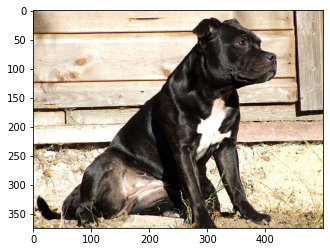

In [ ]:
plt.imshow(image) # original image

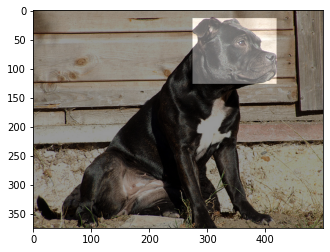

In [ ]:
plt.imshow(image)
plt.imshow(mask[:, :, 0], cmap="gray", alpha=0.4) # bounding box of the image

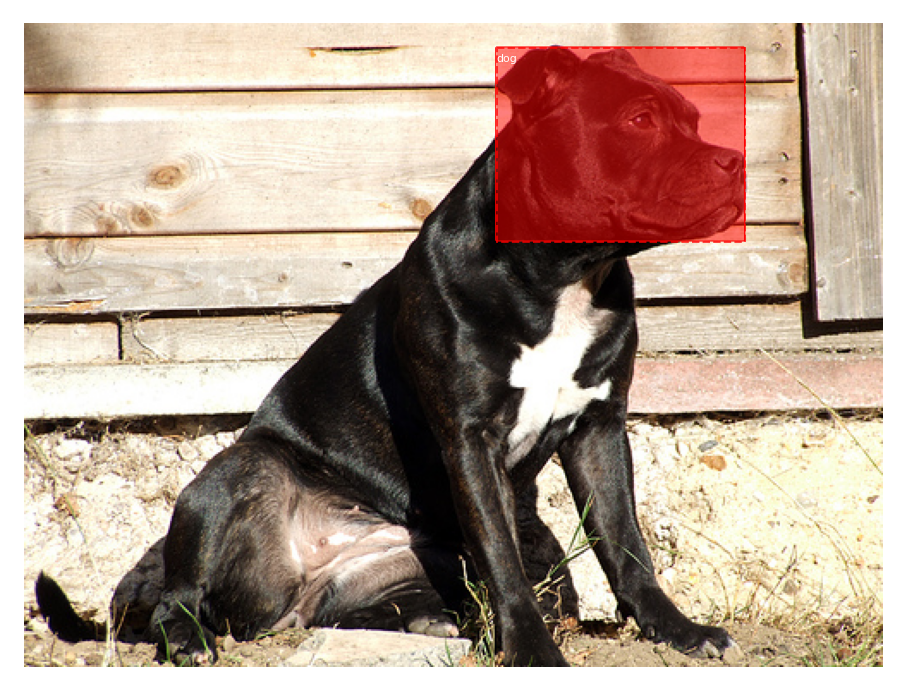

In [ ]:
from mrcnn.utils import extract_bboxes
from mrcnn.visualize import display_instances

bbox = extract_bboxes(mask)
display_instances(image, bbox, mask, class_ids, train_set.class_names)  # mask of the image - recall that I had used the bounding boxes
                                                                        # as the masks

<h3>Train the Model <h3>

In [ ]:
# Mask R-CNN model requires a config object to handle training process (e.g. callbacks)
from mrcnn.config import Config

class DogvsCatConfig(Config):
    NAME = "dogvscat_cfg"
    NUM_CLASSES = 1 + 2    # 1 class for background of image - 2 classes for object in the image (dogs and cats)
    STEPS_PER_EPOCH = 3001

In [ ]:
config = DogvsCatConfig()

In [ ]:
from mrcnn.model import MaskRCNN

model = MaskRCNN(mode="training", model_dir="../models", config=config) # create the model

# load the model weights - I had downloaded the top cell of notebook
# since I am going to train this model with custom dataset, I excluded some layers of the pretrained model
model.load_weights("mask_rcnn_coco.h5", by_name=True, exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", "mrcnn_bbox", "mrcnn_mask"])







Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
box_ind is deprecated, use box_indices instead








In [ ]:
model.train(train_set, test_set, learning_rate=config.LEARNING_RATE, epochs=5, layers="heads") # just do the magic
# you can change the learning rate as you want - in that case it is 0.1
# by the way, this train is going to take a while, up to 4 hours


Starting at epoch 0. LR=0.001

Checkpoint Path: ../models/dogvscat_cfg20210317T1345/mask_rcnn_dogvscat_cfg_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_bn4 

/tensorflow-1.15.2/python3.7/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.7/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.7/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


/usr/local/lib/python3.7/dist-packages/keras/engine/training_generator.py:47: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'




Epoch 1/5
3001/3001 [==============================] - 2725s 908ms/step - loss: 0.7979 - rpn_class_loss: 0.0046 - rpn_bbox_loss: 0.2978 - mrcnn_class_loss: 0.0375 - mrcnn_bbox_loss: 0.2274 - mrcnn_mask_loss: 0.2305 - val_loss: 0.9793 - val_rpn_class_loss: 0.0087 - val_rpn_bbox_loss: 0.5821 - val_mrcnn_class_loss: 0.0306 - val_mrcnn_bbox_loss: 0.1575 - val_mrcnn_mask_loss: 0.2004

Epoch 2/5
3001/3001 [==============================] - 2671s 890ms/step - loss: 0.5425 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.2144 - mrcnn_class_loss: 0.0327 - mrcnn_bbox_loss: 0.1130 - mrcnn_mask_loss: 0.1789 - val_loss: 0.4851 - val_rpn_class_loss: 0.0020 - val_rpn_bbox_loss: 0.1832 - val_mrcnn_class_loss: 0.0330 - val_mrcnn_bbox_loss: 0.1055 - val_mrcnn_mask_loss: 0.1615
Epoch 3/5
3001/3001 [==============================] - 2670s 890ms/step - loss: 0.4645 - rpn_class_loss: 0.0028 - rpn_bbox_loss: 0.1837 - mrcnn_class_loss: 0.0277 - mrcnn_bbox_loss: 0.0884 - mrcnn_mask_loss: 0.1620 - val_loss: 0.5685

<h3>Results<h3>

In [ ]:
!cp ../models/dogvscat_cfg20210317T1345/mask_rcnn_dogvscat_cfg_0005.h5 ../gdrive/MyDrive # I copy the trained model weights to my drive

In [ ]:
# As in the training, the model also requires a config object for prediction
from mrcnn.config import Config

class PredictionConfig(Config):
    NAME = "dogvscat_cfg"
    NUM_CLASSES = 1 + 2
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

In [ ]:
from mrcnn.model import MaskRCNN

cfg = PredictionConfig()
model = MaskRCNN(mode="inference", model_dir="./test", config=cfg) # due to I saved the best model to the drive and now I continue at other time
                                                                   # I have to load it again and for this purpose I have to create
                                                                   # another model, if you were continue after training without closing 
                                                                   # the notebook, you can use the model variable as usual








Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
box_ind is deprecated, use box_indices instead


Instructions for updating:
Use `tf.cast` instead.


In [ ]:
model.load_weights("../gdrive/MyDrive/mask_rcnn_dogvscat_cfg_0005.h5", by_name=True) # load the weights from drive

In [ ]:
# To evaluate the model's performance, I used the mean average precision
from mrcnn.model import load_image_gt
from mrcnn.model import mold_image
from mrcnn.utils import compute_ap

def evaluate_model(dataset, model, cfg):
    APs = list()
    for image_id in dataset.image_ids: # a loop over the dataset
        image, image_meta, gt_class_id, gt_bbox, gt_mask = load_image_gt(dataset, cfg, image_id, use_mini_mask=False) # load image
        scaled_image = mold_image(image, cfg)      # scale it
        sample = np.expand_dims(scaled_image, 0)   
        yhat = model.detect(sample, verbose=0)     # to the prediction
        r = yhat[0]

        AP, _, _, _ = compute_ap(gt_bbox, gt_class_id, gt_mask, r["rois"], r["class_ids"], r["scores"], r["masks"])
        APs.append(AP)

    mAP = np.mean(APs)

    return mAP

In [ ]:
train_mAP = evaluate_model(train_set, model, cfg)  # calculate score on train set
print("Train mAP:", train_mAP)

test_mAP = evaluate_model(test_set, model, cfg)    # and also test
print("Test mAP:", test_mAP)

Train mAP: 0.9613462179273575
Test mAP: 0.9329446064139941


In [ ]:
# a function to draw results

from matplotlib import pyplot as plt
import matplotlib as mpl
labels = ["BG", "Dog", "Cat"]

def detect_objects(image, model=model, cfg=cfg):
    scaled_image = mold_image(image, cfg)
    sample = np.expand_dims(scaled_image, 0)
    yhat = model.detect(sample)[0]

    plt.imshow(image)
    ax = plt.gca()

    for box, score, id in zip(yhat["rois"], yhat["scores"], yhat["class_ids"]):
        y1, x1, y2, x2 = box
        width, height = (x2 - x1), (y2 - y1)
        rect = mpl.patches.Rectangle((x1, y1), width, height, fill=False, color="red")
        plt.text(x1, y1 - 5, "{} % {:.3f}".format(labels[id], (score * 100)), backgroundcolor="red")
        ax.add_patch(rect)

In [ ]:
# a wrapper function to draw results with the image path - for the images which downloaded directly from web
def detect_with_path(path):
    detect_objects(mpl.image.imread(path))

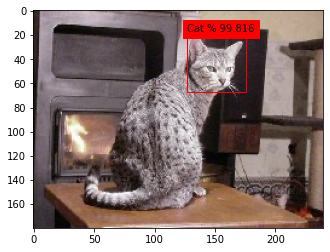

In [ ]:
# let's see an image's prediction

image = test_set.load_image(11)
detect_objects(image)

In [ ]:
# and trying the model an image that it has never seen - for example from web
!wget https://storage.googleapis.com/petbacker/images/blog/2017/dog-and-cat-cover.jpg

--2021-03-18 07:50:43--  https://storage.googleapis.com/petbacker/images/blog/2017/dog-and-cat-cover.jpg
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.213.128, 173.194.214.128, 173.194.215.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.213.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 72452 (71K) [image/jpeg]
Saving to: ‘dog-and-cat-cover.jpg’

dog-and-cat-cover.j 100%[===================>]  70.75K  --.-KB/s    in 0.001s  

2021-03-18 07:50:43 (105 MB/s) - ‘dog-and-cat-cover.jpg’ saved [72452/72452]



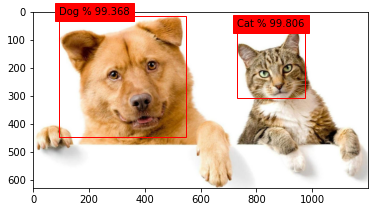

In [ ]:
detect_with_path("dog-and-cat-cover.jpg")